# **Cyber Attacks Classification using DistilBERT**

> **Presented by:**
> 
> Tomer Grossman & Oriel Somech
> 
> **Academic Advisor:**
>
> Dr. Guy Leshem
>
> 
> **Computer Science Department**
> 
> **CLB - Ramat Gan Academic Center**

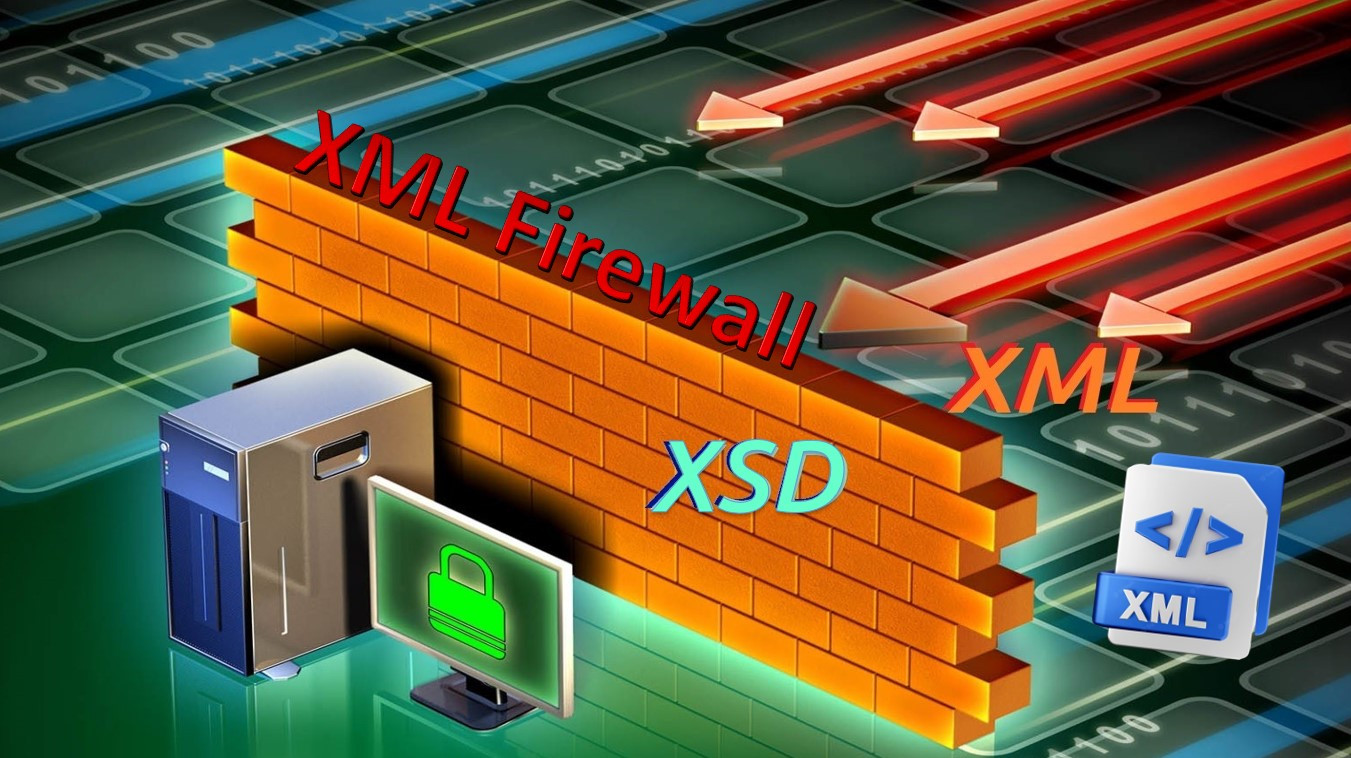

> **This notebook demonstrates how to use the DistilBERT model, a powerful natural language processing (NLP) model, to classify different types of cyber attacks. The dataset used contains examples of SQL injection, Denial of Service (DoS), and XML External Entity (XXE) attacks, along with a "none" category for non-attacks. The notebook covers the steps of data preprocessing, model training, evaluation, and saving the trained model for future use. It includes visualizations such as training and validation accuracy plots and a confusion matrix to assess the model's performance. By following this notebook, you will gain insights into training an NLP model to classify cyber attacks and learn how to apply it in real-world scenarios.**

* # **Model We Use - DistilBERT**

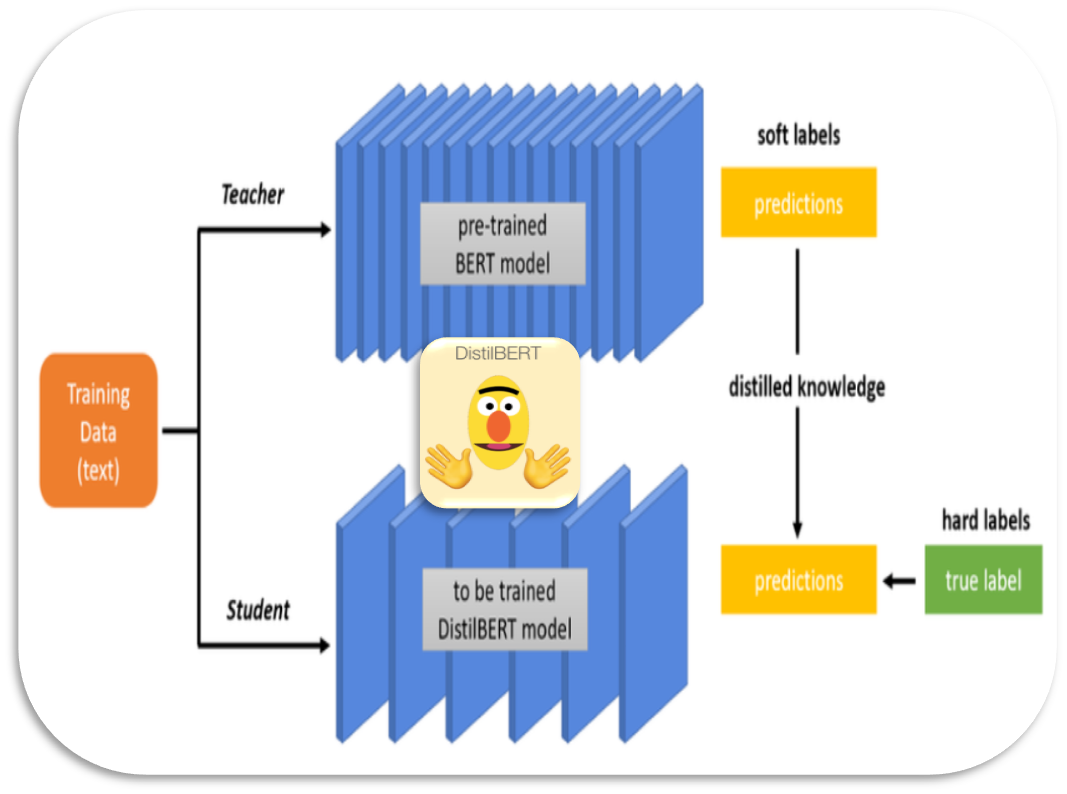 
> **Examlpe of the DistilBERT model architecture**
>
>DistilBERT is a smaller and faster version of the BERT model. It retains BERT's ability to understand the meaning of words in context but with fewer layers and reduced size.
>
>DistilBERT is trained using a technique called knowledge distillation from a larger BERT (Bidirectional Encoder Representations from Transformers) model. Knowledge distillation involves transferring the knowledge learned by a larger, more complex model to a smaller and more efficient model.

* # **SQL Injection Example**
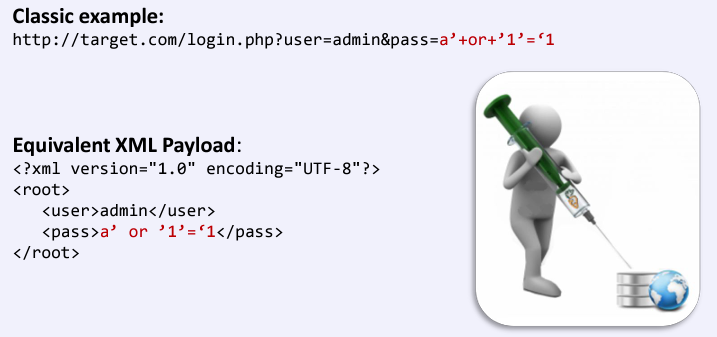
> A XML with SQL Injection attack can inject source code into a application such that it can be interpreted and run as a valid SQL query to perform a database operation with malicious intent. 
>
>For example, XML SQL attacks can be launched to gain unauthorized access to the contents of a database or to manipulate the stored data. 
>
>XML SQL Injection attacks are not only common, but can also be very harmful and costly.

* # **XXE - XML External Entity Example**
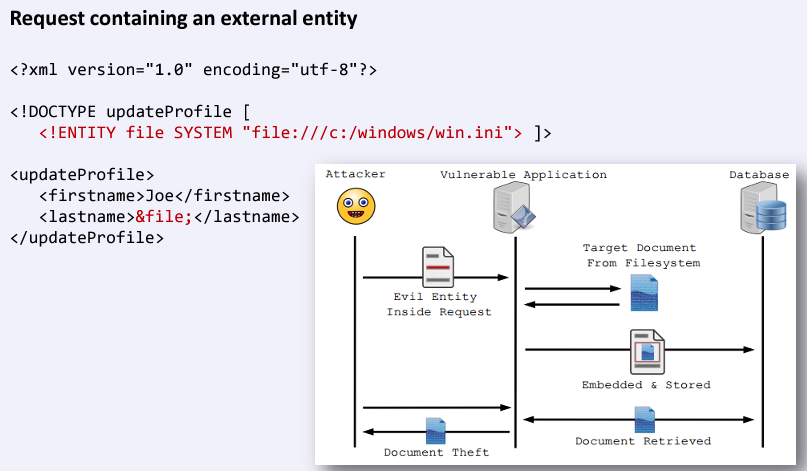
> XML external entity injection (also known as XXE) is a web security vulnerability that allows an attacker to interfere with an application's processing of XML data. It often allows an attacker to view files on the application server filesystem, and to interact with any back-end or external systems that the application itself can access.

* # **DOS - Denial Of Service Example**
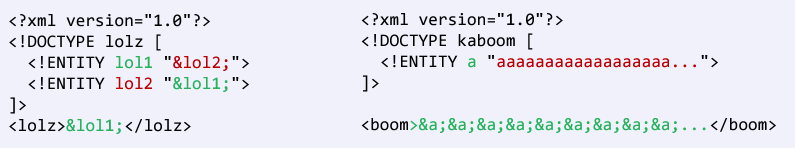
>A denial-of-service attack (DoS attack) is a cyber-attack where the attacker looks to make a machine or network resource unavailable.
>
>One type of especially nasty XML DoS attack is the XML bomb—a block of XML that is both well-formed and valid according to the rules of an XML schema but which crashes or hangs a program when that program attempts to parse it.


# 1.  **Import Dependencies**

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# **2. Load and Preprocess Data**

In [2]:
# Set the device for training (CPU or GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv('/kaggle/input/injections/injections_dataset.csv')

# Split the dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'], df['label'], test_size=0.4, random_state=42
)
valid_texts, test_texts, valid_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)


# Create a custom Dataset class for loading the data
class CyberAttacksDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])  # Use .iloc[idx] to access by index
        label = self.labels.iloc[idx]  # Use .iloc[idx] to access by index
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label
        }

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define the maximum sequence length for tokenization
max_length = 128

# Create Dataset instances for train, validation, and test sets
train_dataset = CyberAttacksDataset(train_texts, train_labels, tokenizer, max_length)
valid_dataset = CyberAttacksDataset(valid_texts, valid_labels, tokenizer, max_length)
test_dataset = CyberAttacksDataset(test_texts, test_labels, tokenizer, max_length)


# **3. Model Training**

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.

Epoch 1/2
Train Loss: 0.0320 | Train Acc: 0.9928
Valid Loss: 0.0044 | Valid Acc: 0.9989
------------------------------
Epoch 2/2
Train Loss: 0.0033 | Train Acc: 0.9992
Valid Loss: 0.0037 | Valid Acc: 0.9990
------------------------------


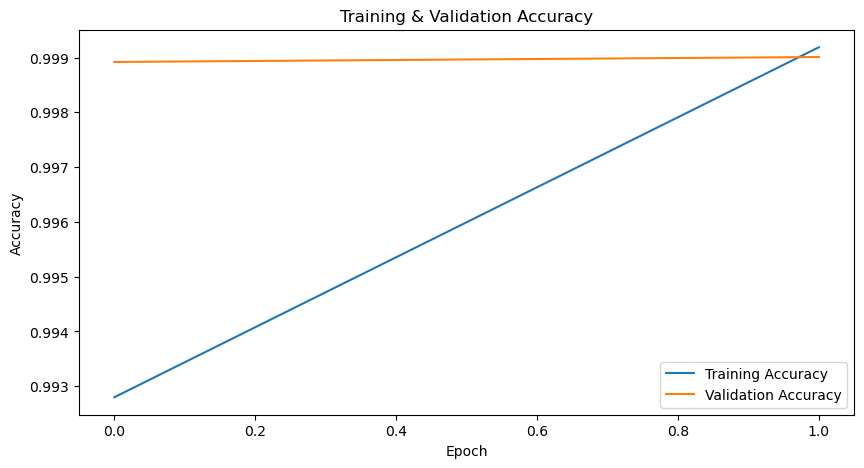

In [3]:
# Set the device for training (CPU or GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the batch size and number of training epochs
batch_size = 16
num_epochs = 2

# Create data loaders for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# Initialize the DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=4  # 4 categories: SQL injection, DoS, XXE, none
)
model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training loop
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy_score(labels.cpu(), preds.cpu())

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0

    with torch.no_grad():
        for batch in valid_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            loss = loss_fn(logits, labels)

            valid_loss += loss.item()
            valid_acc += accuracy_score(labels.cpu(), preds.cpu())

    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)

    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')
    print('-' * 30)

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(valid_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()


# **4. Evaluation**

Test Loss: 0.0040 | Test Acc: 0.9987


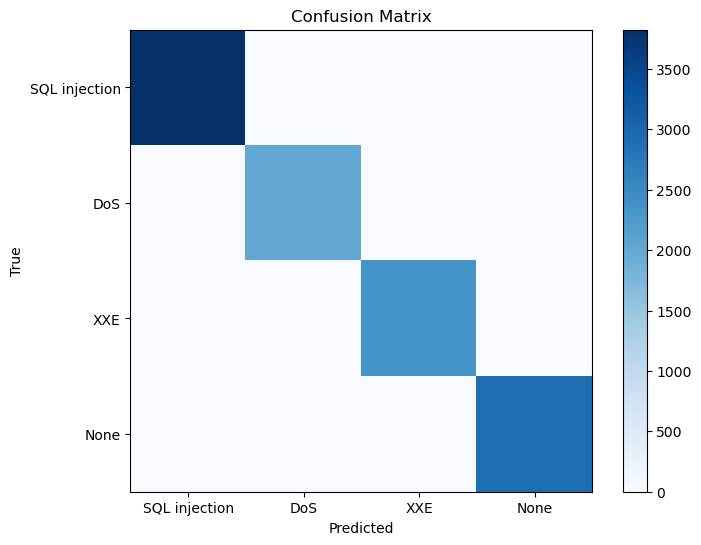

In [4]:
# Create a data loader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Evaluation on test set
model.eval()
test_loss = 0.0
test_acc = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        loss = loss_fn(logits, labels)

        test_loss += loss.item()
        test_acc += accuracy_score(labels.cpu(), preds.cpu())

        predictions.extend(preds.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())

test_loss /= len(test_loader)
test_acc /= len(test_loader)

print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(4), ['SQL injection', 'DoS', 'XXE', 'None'])
plt.yticks(range(4), ['SQL injection', 'DoS', 'XXE', 'None'])
plt.show()


# **5. Save the Trained Model**

In [5]:
# Save the trained model
output_dir = './saved_model'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

# Finally we use the trained model in a software, thus the model will be implemented inside and classify cyber attacks in XML files